In [2]:
%matplotlib inline

import os
import glob
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib import slim

import matplotlib.pyplot as plt
from IPython.display import display

import util
import dataset_util
import celeba_dataset

reload(util);
reload(dataset_util);
reload(celeba_dataset);

# Celeba

In [ ]:
# 256 x 256

def make_generator(noise, is_training):
    with slim.arg_scope(
        [layers.conv2d_transpose, layers.conv2d],
        padding='SAME',
        activation_fn=tf.nn.relu,
        normalizer_fn=layers.batch_norm,
        normalizer_params={'is_training': is_training,
                           'updates_collections': None}):
        top = layers.flatten(noise)
        top = util.linear(top, 8 * 8 * 1024)
        top = tf.reshape(top, [-1, 8, 8, 1024])
        top = layers.conv2d_transpose(top, 512, [5, 5], stride=2)
        top = layers.conv2d_transpose(top, 256, [5, 5], stride=2)
        top = layers.conv2d_transpose(top, 128, [5, 5], stride=2)
        top = layers.conv2d_transpose(top, 64, [5, 5], stride=2)
        top = layers.conv2d_transpose(top, 3, [5, 5], stride=2,
                                      activation_fn=tf.sigmoid,
                                      normalizer_fn=None)
        return top


def make_discriminator(data, is_training):
    with slim.arg_scope(
        [layers.conv2d],
        padding='SAME',
        activation_fn=util.make_leaky_relu(0.2),
        normalizer_fn=layers.batch_norm,
        normalizer_params={'is_training': is_training,
                           'updates_collections': None}):
    
        top = data
        top = layers.conv2d(top, 32, [3, 3], stride=2, normalizer_fn=None)
        top = layers.conv2d(top, 32, [3, 3], stride=1)
        top = layers.conv2d(top, 64, [3, 3], stride=2)
        top = layers.conv2d(top, 64, [3, 3], stride=1)
        top = layers.conv2d(top, 128, [3, 3], stride=2)
        top = layers.conv2d(top, 128, [3, 3], stride=1)
        top = layers.conv2d(top, 256, [3, 3], stride=2)
        top = layers.conv2d(top, 256, [3, 3], stride=1)
        top = layers.conv2d(top, 512, [3, 3], stride=2)
        top = layers.conv2d(top, 512, [3, 3], stride=1)
        top = layers.flatten(top)
        data_logit = util.linear(top, 1)
        return data_logit
    

train_dir = 'celeba_hresgan_v2_logs'
shutil.rmtree(train_dir, ignore_errors=True)
batch_size = 8
image_size = 256
noise_dim = 200
with tf.Graph().as_default():
    dataset = celeba_dataset.Dataset('../CelebA', image_size)
    iterator = dataset.make_iterator(batch_size=batch_size)
    next_elem = iterator.get_next()
    
    real_data = next_elem.pop(celeba_dataset.IMAGE_KEY)
    real_data.set_shape((batch_size, image_size, image_size, 3))
    noise = tf.random_normal(shape=(batch_size, noise_dim))
    
    global_step = tf.contrib.framework.get_or_create_global_step()
    
    total_num_steps = 1000000
    
    data_noise_mag = 0.1
    num_annealing_steps = int(total_num_steps / 10)
    annealing_schedule = tf.cond(
        global_step < num_annealing_steps,
        lambda: data_noise_mag * (
            -1.0 / num_annealing_steps * tf.cast(global_step, tf.float32) + 1.0),
        lambda: tf.constant(0.0, dtype=tf.float32))
    data_noise = tf.random_normal(shape=real_data.get_shape()) * annealing_schedule
    
    # Build model
    with tf.variable_scope('generator') as gen_scope:
        gen_data = make_generator(noise, is_training=True)
    
    with tf.variable_scope('discriminator') as dis_scope:
        dis_gen_logit = make_discriminator(
            gen_data + data_noise, is_training=True)
        
    with tf.variable_scope(dis_scope, reuse=True):
        dis_real_logit = make_discriminator(
            real_data + data_noise, is_training=True)
    
    with tf.variable_scope(gen_scope, reuse=True):
        test_noise = tf.placeholder(dtype=tf.float32, shape=(None, noise_dim))
        test_data = make_generator(test_noise, is_training=False)
    
    # Add test variables to collections
    tf.add_to_collection('celeba/noise', test_noise)
    tf.add_to_collection('celeba/data', test_data)

    # Loss
    gen_loss = -tf.losses.sigmoid_cross_entropy(
        tf.zeros_like(dis_gen_logit), dis_gen_logit)
    
    dis_loss = (
        tf.losses.sigmoid_cross_entropy(
            tf.zeros_like(dis_gen_logit), dis_gen_logit) +
        tf.losses.sigmoid_cross_entropy(
            tf.ones_like(dis_real_logit), dis_real_logit)
    )
    
    # Train ops
    
    gen_vars = util.get_trainable_variables_in_scope(gen_scope)
    dis_vars = util.get_trainable_variables_in_scope(dis_scope)
    
    optim = tf.train.AdamOptimizer(1.0e-4, beta1=0.5, beta2=0.99)
    gen_train_op = optim.minimize(
        loss=gen_loss, var_list=gen_vars, global_step=global_step)
    
    optim = tf.train.AdamOptimizer(1.0e-4, beta1=0.5, beta2=0.99)
    dis_train_op = optim.minimize(
        loss=dis_loss, var_list=dis_vars, global_step=global_step)
        
    tf.summary.scalar('gen_loss', gen_loss)
    tf.summary.scalar('dis_loss', dis_loss)
    summary_op = tf.summary.merge_all()
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer(), feed_dict=dataset.feed_dict)
        sess.run(iterator.initializer, feed_dict=dataset.feed_dict)
        
        summary_writer = tf.summary.FileWriter(
            logdir=train_dir, graph=sess.graph)
        
        with util.TensorflowQueues(sess):
            step = 0
            dis_step = 0
            gen_step = 0
            dis_loss_value = 0.0
            gen_loss_value = 0.0
            while step < total_num_steps:
                if gen_loss_value < -np.log(2.0):
                    _, dis_loss_value = sess.run([dis_train_op, dis_loss])
                    dis_step += 1
                if dis_loss_value < 2.0 * np.log(2.0):
                    _, gen_loss_value = sess.run([gen_train_op, gen_loss])
                    gen_step += 1
            
                step = sess.run(global_step)
                if step % 100 == 0:
                    print ('Global step {}: gen_loss = {}, dis_loss = {}, '
                           'gen_step = {}, dis_step = {}, annealing_schedule = {}').format(
                        step, gen_loss_value, dis_loss_value, gen_step, dis_step,
                        sess.run(annealing_schedule))
                    
                    print 'Writing summaries'
                    summary_proto = sess.run(summary_op)
                    summary_writer.add_summary(summary_proto, global_step=step)
                if step % 1000 == 0:
                    print 'Writing checkpoint'
                    saver.save(sess, os.path.join(train_dir, 'model'), global_step=step)
                    
                    feed_dict = {
                        test_noise: np.random.normal(size=(5, noise_dim))
                    }
                    test_data_value = sess.run(test_data, feed_dict=feed_dict)
                    util.plot_rgb_images(test_data_value)
                    
                    print '='*50

In [37]:
# Test
class Inference(util.InferenceBase):
    
    def __init__(self, train_log):
        super(Inference, self).__init__(train_log)
        with self._graph.as_default():
            self._noise_placeholder = tf.get_collection('celeba/noise')[0]
            self._noise_dim = self._noise_placeholder.get_shape()[1]
            self._data = tf.get_collection('celeba/data')[0]

    def get_noise(self, batch_size):
        return np.random.normal(size=(batch_size, self._noise_dim))
    
    def infer(self, batch_size=None, noise=None):
        if noise is None:
            assert batch_size is not None
            noise = np.random.normal(
                size=(batch_size, self._noise_dim))
        feed_dict = {
            self._noise_placeholder: noise,
        }
        data = self._sess.run(self._data, feed_dict=feed_dict)
        return data, noise
    

inference = Inference('celeba_hresgan_v2_logs')

INFO:tensorflow:Restoring parameters from celeba_hresgan_v2_logs/model-585000


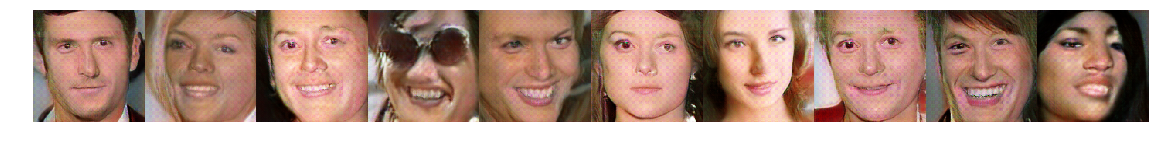

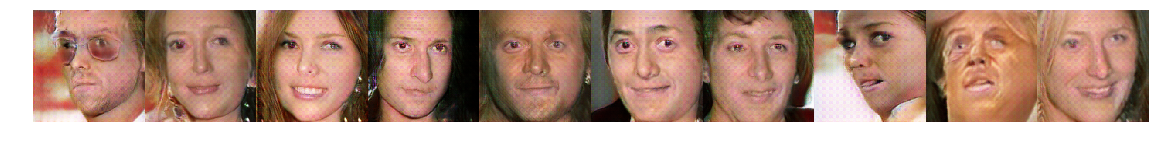

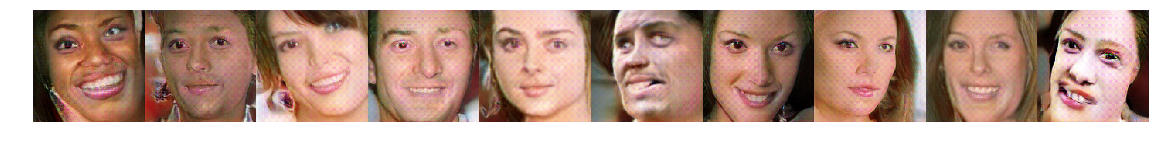

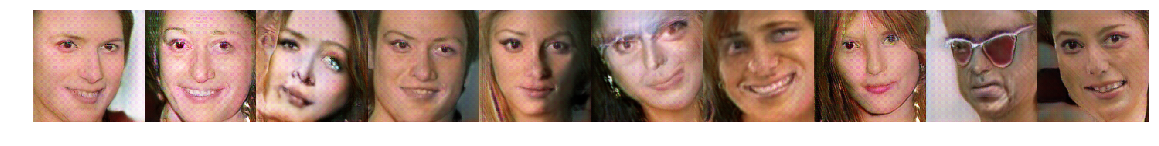

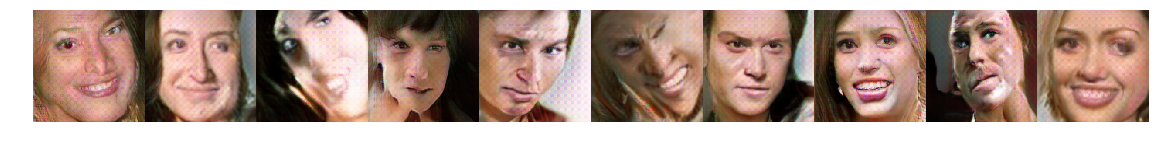

In [8]:
for i in range(5):
    data, _ = inference.infer(10)
    util.plot_rgb_images(data)

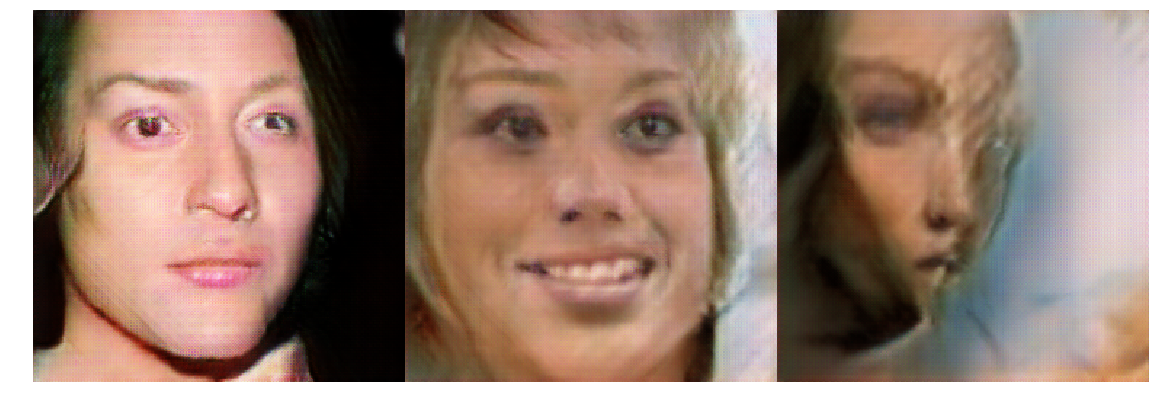

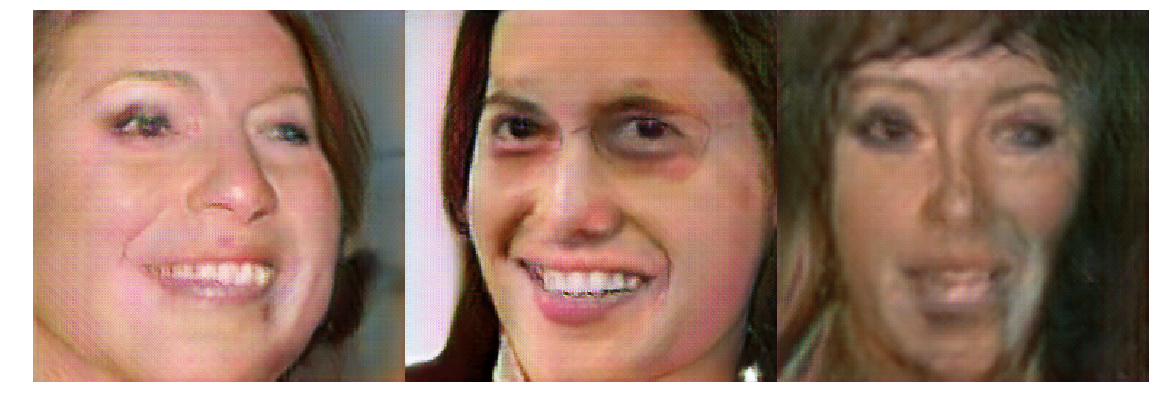

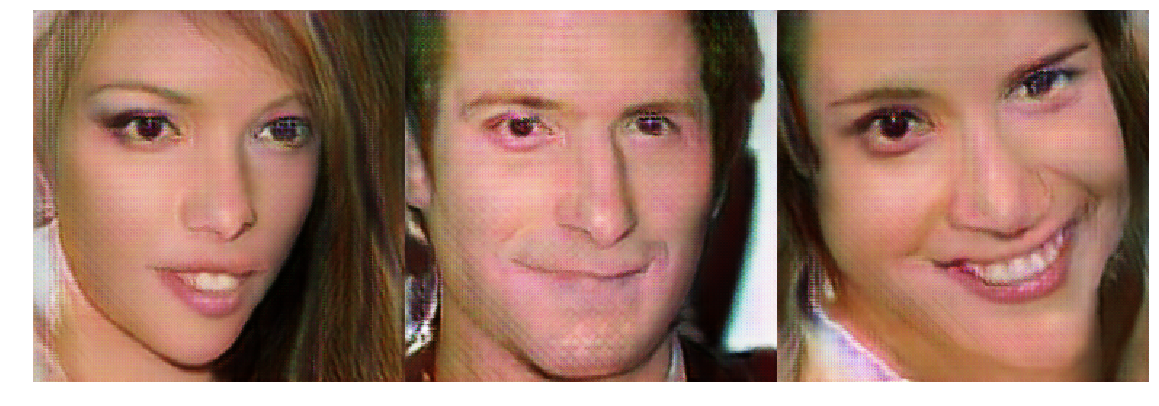

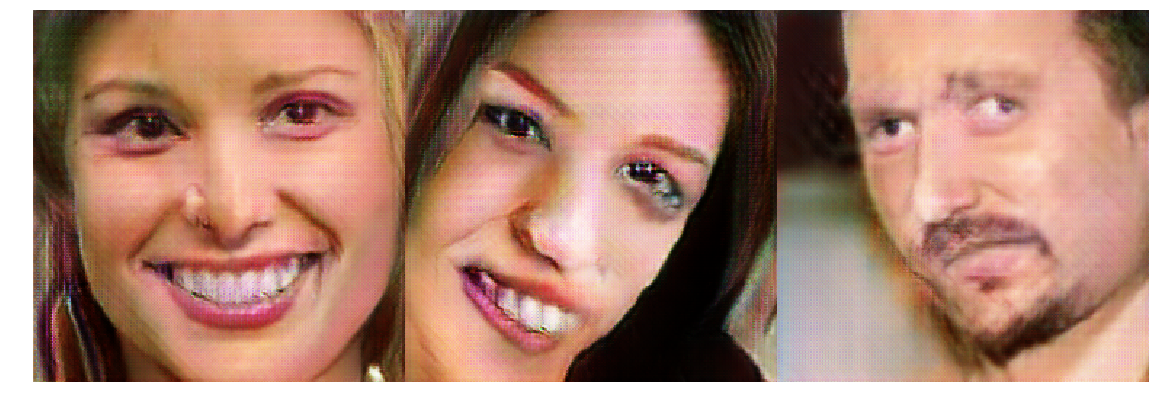

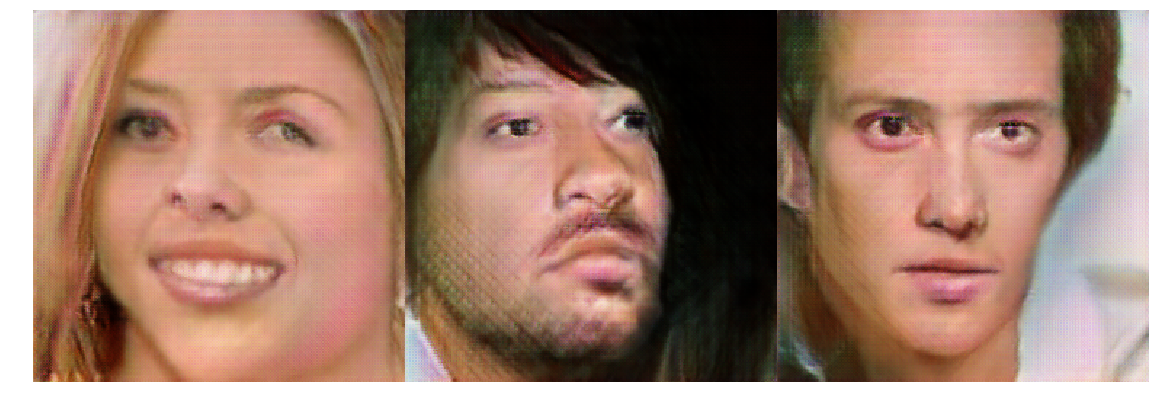

In [17]:
for i in range(5):
    data, _ = inference.infer(3)
    util.plot_rgb_images(data)

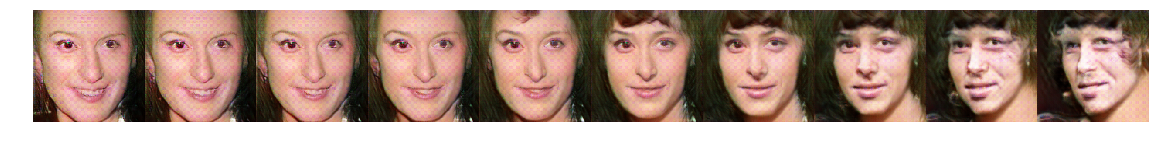

In [60]:
# Latent space walkthrough
end_noises = inference.get_noise(2)
n = 10
noise = np.stack([
    end_noises[0] + (end_noises[1] - end_noises[0]) * a
    for a in np.arange(n) / float(n-1)
])
data, _ = inference.infer(noise=noise)
util.plot_rgb_images(data)